# Preamble

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(style="white")

# Allows for interactive shell - outputs all non variable statements
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
np.set_printoptions(precision=4, linewidth=100)

from matplotlib import pyplot as plt

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

model = VGG16(weights='imagenet', include_top=True)

# Use Keras Vgg16 to get the predictions

* Inspect the data
* Prepare a single image
* Feed it into pretrained vgg16

## Inspect the data

Graph the image

Archive:  test.zip
  inflating: /tmp/cats_dogs/1.jpg    


(0.0, 1.0, 0.0, 1.0)

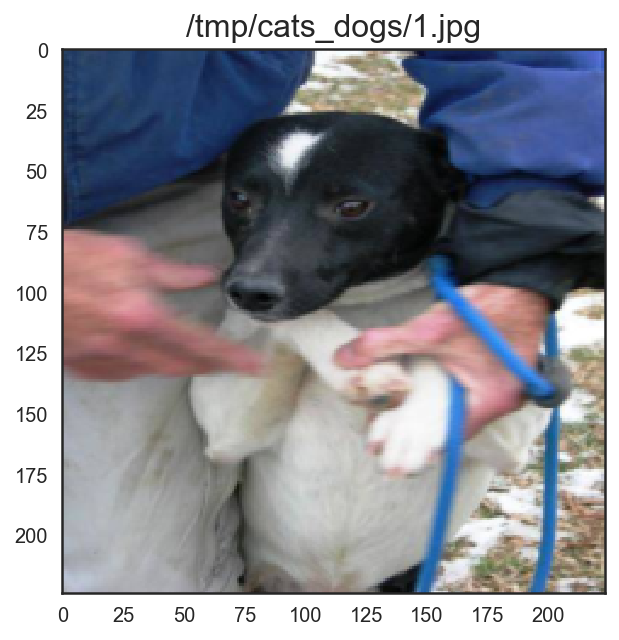

In [21]:
# Unzip a single file to test on the pretrained model
!unzip -oj "test.zip" "test/1.jpg" -d "/tmp/cats_dogs"

# Load the image
img_path = '/tmp/cats_dogs/1.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Plot the single image
f = plt.figure(figsize=(10, 5))
sp = f.add_subplot(1, 1, 1) ## (rows, cols, index)
sp.axis('On')
sp.set_title(img_path, fontsize=16)
plt.imshow(img)

## Prepare image for model

In [6]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

## Predict using Keras Vgg16

In [7]:
preds = model.predict(x)
decode_predictions(preds)

[[('n02087046', 'toy_terrier', 0.24940069),
  ('n02091032', 'Italian_greyhound', 0.21436115),
  ('n02085620', 'Chihuahua', 0.20003819),
  ('n02105412', 'kelpie', 0.081245378),
  ('n02104365', 'schipperke', 0.069995634)]]

# Kaggle Competition

1. Prepare dataset
    1. Download the dataset
    1. Unzip training and test dataset
    1. Create the training, validation, sample batch dataset
    1. Create the labels
1. Model preparation
    1. Finetune the keras model
       1. Pop the last layer, freeze all layers, add a softmax layer and update set of classes
    1. Fit the keras model
       1. Train the updated keras model
    1. Save and load the model after couple of epochs
1. Perform predictions
1. Debug
   1. View the confusion matrix
   1. Visual Inspection
       1. Inspect correct labels
       1. Inspect incorrect labels
       1. Inspect correct labels with high probability
       1. Inspect incorrect label with high probability
       1. Inspect correct labels with medium probability
1. Kaggle Submission
    1. Prepare csv file
    1. Submit


## Prepare dataset

### Download the dataset

```
kg download -c 'dogs-vs-cats-redux-kernels-edition'
```

### Unzip training and test dataset

In [ ]:
import os
import shutil
from glob import glob
np.random.seed(10)

current_dir = os.getcwd()
DATASET_DIR=os.path.join(current_dir, 'dataset')
CROSSVALID_DIR=os.path.join(DATASET_DIR, 'cross_valid')
TRAIN_DIR = os.path.join(DATASET_DIR, 'train')
TEST_DIR = os.path.join(DATASET_DIR, 'test')
CROSSVALID_DIR = os.path.join(DATASET_DIR, 'cross_valid')
SAMPLE_DIR = os.path.join(DATASET_DIR, 'sample')

WEIGHTS_DIR = os.path.join(DATASET_DIR, 'weights')

In [13]:
# Start from fresh
!rm -rf dataset
!mkdir dataset
!unzip -q train.zip -d $DATASET_DIR
!unzip -q test.zip -d $DATASET_DIR
!tree -d

.
├── dataset
│   ├── test
│   └── train
└── utils

4 directories


In [16]:
!find . -maxdepth 5 -type d -exec sh -c "echo '{}'; ls -1 '{}' | wc -l" \; \
   | xargs -n 2 | awk '{print $1" "$2}'

. 7
./dataset 2
./dataset/test 12500
./dataset/train 25000
./utils 4
./.ipynb_checkpoints 1


#### Prepare the training, crossvalidation, sample dataset along with classification

### Create the training, validation, sample batch dataset

1. There are 12,500 images in the test set.
1. There are 25,000 images in the train set.
1. We need to create and move 10% of `train` to a cross validation set.
1. We will also create a `sample` set containing 10% of the remaining `train` set which will be copied from `train`. The `sample` will be used to test the training process of the model before fully training the model using the `train` model.
    1. `sample/train` can contain 200 samples from `train`.
    1. `sample/test` can contain 50 samples from `train`.

So, the directory structure would be:
```
dataset/train/
dataset/cross_valid/
dataset/sample/train/
dataset/sample/cross_valid/

dataset/test/
```

In [53]:
def create_crossvalidation(perc = 0.1):
    os.makedirs(CROSSVALID_DIR, exist_ok=True)
    g = glob(os.path.join(TRAIN_DIR, '*.jpg'))
    shuf = np.random.permutation(g)
    for i in range(int(shuf.shape[0] * perc)):
        filename = os.path.basename(shuf[i])
        os.rename(shuf[i], os.path.join(CROSSVALID_DIR, filename))

def create_sample(perc=0.1):
    os.makedirs(SAMPLE_DIR, exist_ok=True)
    g = glob(os.path.join(TRAIN_DIR, '*.jpg'))
    shuf = np.random.permutation(g)
    for i in range(int(shuf.shape[0] * perc)):
        filename = os.path.basename(shuf[i])
        shutil.copy(shuf[i], os.path.join(SAMPLE_DIR, filename))

def create_labels(abs_directory, labels = ['cat', 'dog']):
    if labels is None:
        label = 'unknown'
        target_dir=os.path.join(abs_directory, label)
        os.makedirs(target_dir, exist_ok=True)
        for file in glob(os.path.join(abs_directory, '*.jpg')):
            target = os.path.join(target_dir, os.path.basename(file))
            shutil.move(file, target)
    else:
        for label in labels:
            target_dir=os.path.join(abs_directory, label)
            os.makedirs(target_dir, exist_ok=True)
            for file in glob(os.path.join(abs_directory, label + '.*.jpg')):
                target = os.path.join(target_dir, os.path.basename(file))
                shutil.move(file, target)
    
# Create the cross validation set
create_crossvalidation()

# Create the sample set
create_sample()

### Create the labels

In [54]:
# Create labeled directories for each of the sets
create_labels(TRAIN_DIR)
create_labels(CROSSVALID_DIR)
create_labels(SAMPLE_DIR)
create_labels(TEST_DIR, labels=None)

%cd $DATASET_DIR
!find . -maxdepth 5 -type d -exec \
   sh -c "echo '{}'; ls -1 '{}' | wc -l" \; | xargs -n 2 | awk '{print $1" "$2}'

/Users/siva/Documents/personal/courses/machine-learning/fastai/lesson1/dogs-vs-cats-redux-kernels-edition/dataset
. 4
./cross_valid 2
./cross_valid/cat 1232
./cross_valid/dog 1268
./test 1
./test/unknown 12500
./sample 2
./sample/cat 1101
./sample/dog 1149
./train 2
./train/cat 11268
./train/dog 11232


## Model preparation

### Finetune the keras model
* Pop the last layer, freeze all layers, add a softmax layer and update set of classes

In [4]:
from keras.layers.core import Dense
from keras.models import Model
from keras.optimizers import Adam

ttl_outputs = 2
learning_rate = 0.01

base_model = VGG16(weights='imagenet', include_top=True)

inputs = base_model.input
outputs = Dense(ttl_outputs, activation='softmax')(base_model.output)

model = Model(inputs=inputs, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr = learning_rate), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

### Fit the keras model

* Train the updated keras model with the new data for couple of epochs

In [24]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

batch_size = 5
epochs = 1
train_dir = SAMPLE_DIR

nb_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
nb_validation_samples = sum([len(files) for r, d, files in os.walk(CROSSVALID_DIR)])

def process_img(img_path):
    img = image.load_img(img_path, target_size(224,244))
    f = img.img_to_array(img)
    f = np.expand_dims(f, axis=0)
    f = preprocess_input(f)
    return f

# datagen = ImageDataGenerator(preprocessing_function=process_img)
datagen = ImageDataGenerator(
    data_format='channels_last')

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    CROSSVALID_DIR,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
# add preprocessing to the image?

classes = list(iter(train_generator.class_indices))
for c in train_generator.class_indices:
    classes[train_generator.class_indices[c]] = c

train_generator.class_indices
classes

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Found 2250 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


{'cat': 0, 'dog': 1}

['cat', 'dog']

Epoch 1/1
449/450 [============================>.] - ETA: 2s - loss: 0.3597 - acc: 0.9261

KeyboardInterrupt: 

### Save the model after couple of epochs

In [ ]:
!mkdir -p $WEIGHTS_DIR

model.save_weights(os.path.join(WEIGHTS_DIR, 'intial_run_1.h5'))
model.load_weights(os.path.join(WEIGHTS_DIR, 'intial_run_1.h5'))

train_generator.class_indices
??model.evaluate()

## Perform predictions